In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='viridis', font_scale=2, font='times', style='white')

regions = ['nsw', 'sa']
y_axis_var = 'net_load'

dfs = []
for region in regions:
    df = pd.read_csv(f'../data/{region}/merged2.csv')
    df.datetime = df.datetime.astype('datetime64')
    df['region'] = region
    dt = df['datetime'].dt
    df['year'] = dt.year
    dfs.append(df)
df = pd.concat(dfs)
df.head()

,datetime,net_load,total_load,pv_est,tempc_cbr,cloud8_cbr,windk_cbr,wdir_cbr,humid_cbr,rainmm_cbr,...,radkjm2_syd,region,year,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2
0,2018-03-06 10:00:00,8499.5,8332.145,434.3715,19.0,2.0,15.0,110.0,52.0,0.0,...,1710.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-03-06 11:00:00,8457.0,8294.325,468.8860,19.4,1.0,14.0,140.0,49.0,0.0,...,2080.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-03-06 12:00:00,8396.0,8248.405,483.1315,19.1,4.0,15.0,150.0,52.0,0.0,...,2760.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-03-06 13:00:00,8341.5,8193.080,491.4175,19.4,4.0,14.0,140.0,55.0,0.0,...,2840.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-03-06 14:00:00,8321.5,8185.100,487.9780,18.9,7.0,17.0,120.0,57.0,0.0,...,2850.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Univariate distributions

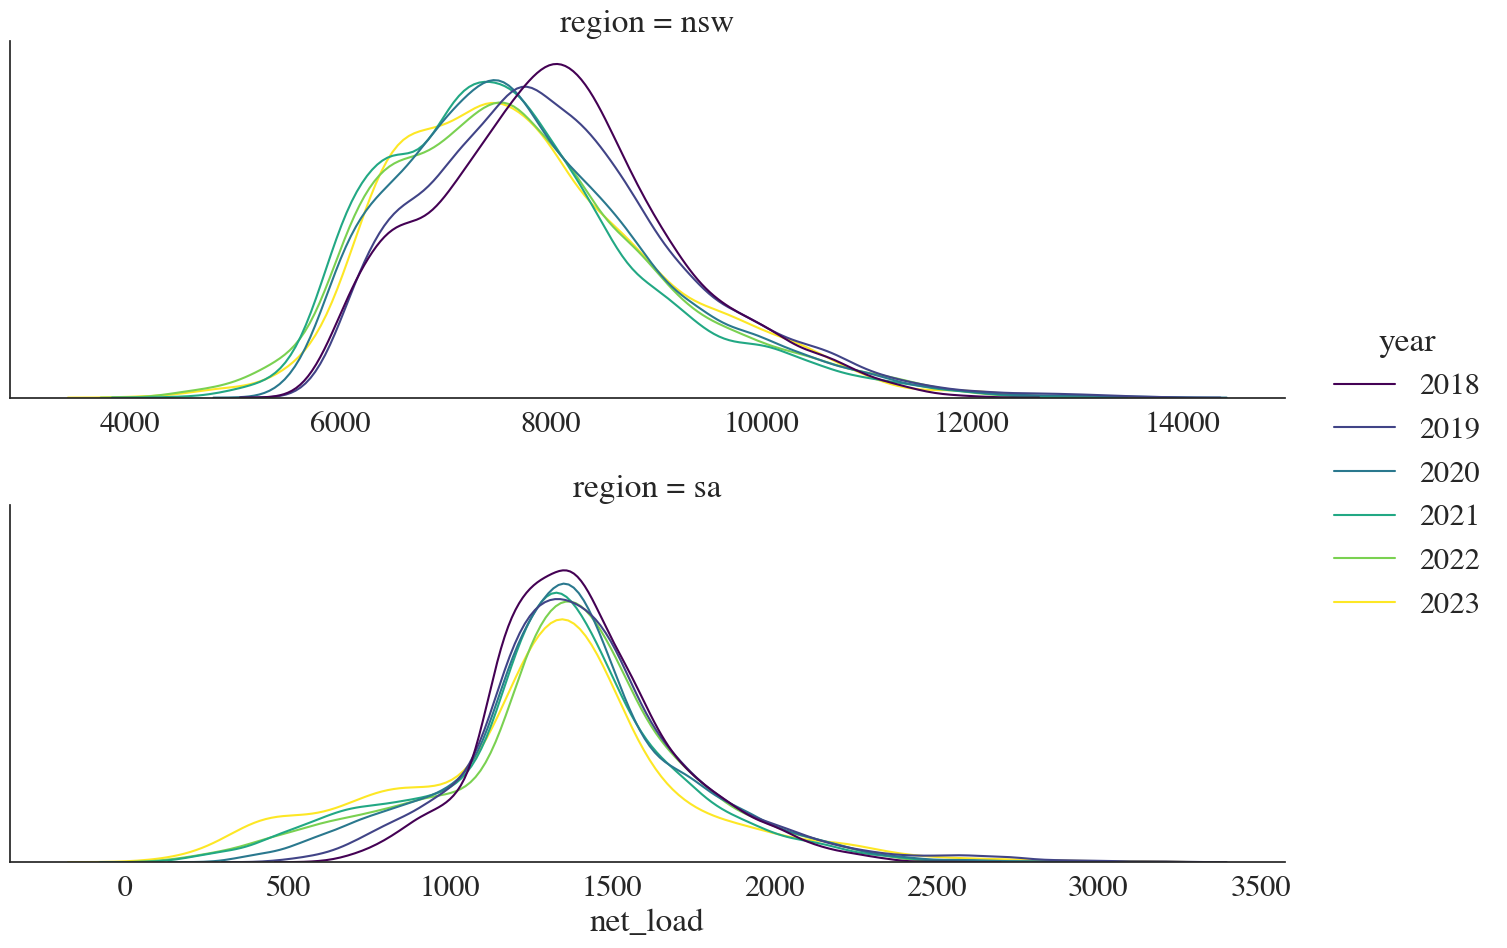

In [27]:
g = sns.displot(df.set_index(['datetime', 'region']), x='net_load', row='region', kind='kde', aspect=3,
                facet_kws={'sharex': False, 'sharey': False}, hue='year', palette='viridis', common_norm=False) #, common_bins=False
g.set_ylabels('')
g.set_yticklabels('')
g.savefig('../plots/net_load_hist')

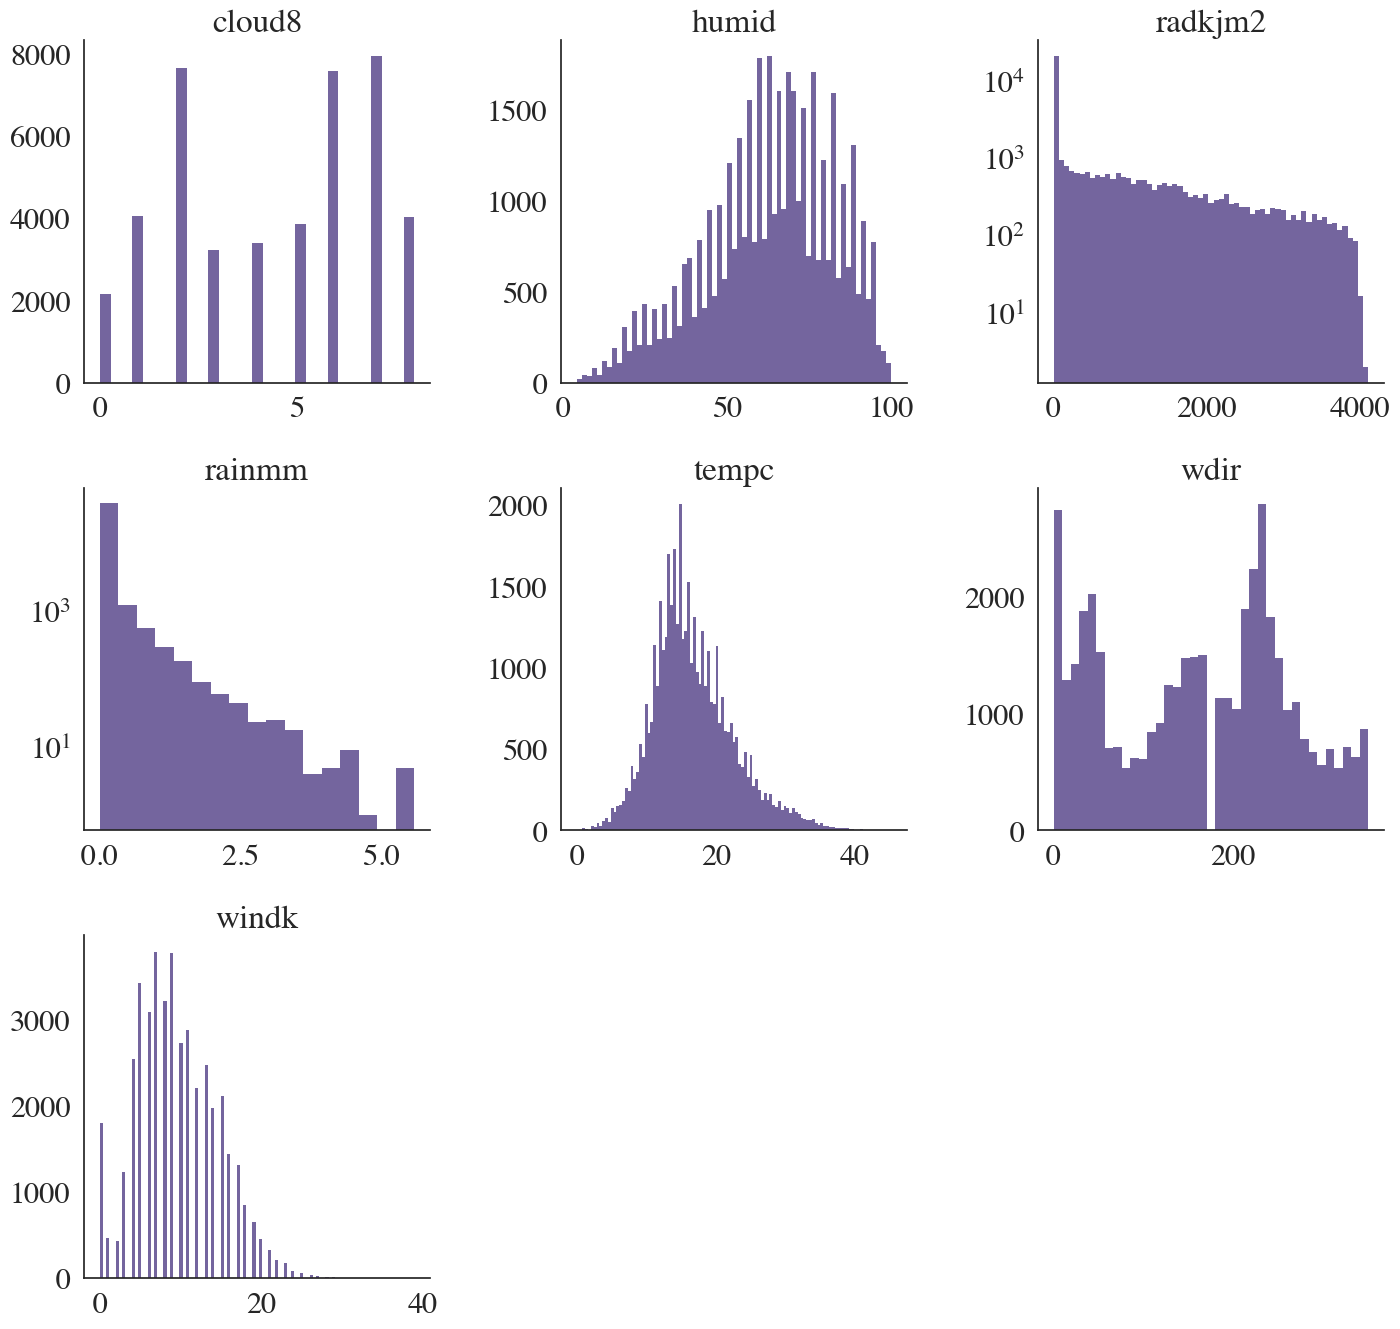

In [28]:
hist_ids = ['datetime', 'region']
hist_vals = ['cloud8', 'humid', 'radkjm2', 'rainmm', 'tempc', 'wdir', 'windk']
log_vals = ['rainmm', 'radkjm2']
hist_df = df[df['region'] == 'sa'].melt(id_vars=hist_ids, value_vars=hist_vals)

g = sns.displot(hist_df, x='value', col='variable', col_wrap=3, kind='hist',
            facet_kws={'sharex': False, 'sharey': False}, common_bins=False)
for col, ax in g.axes_dict.items():
    if col in log_vals:
        ax.set(yscale='log')
g.set_axis_labels('', '')
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.9)
g.savefig('../plots/weather_hist_ade')

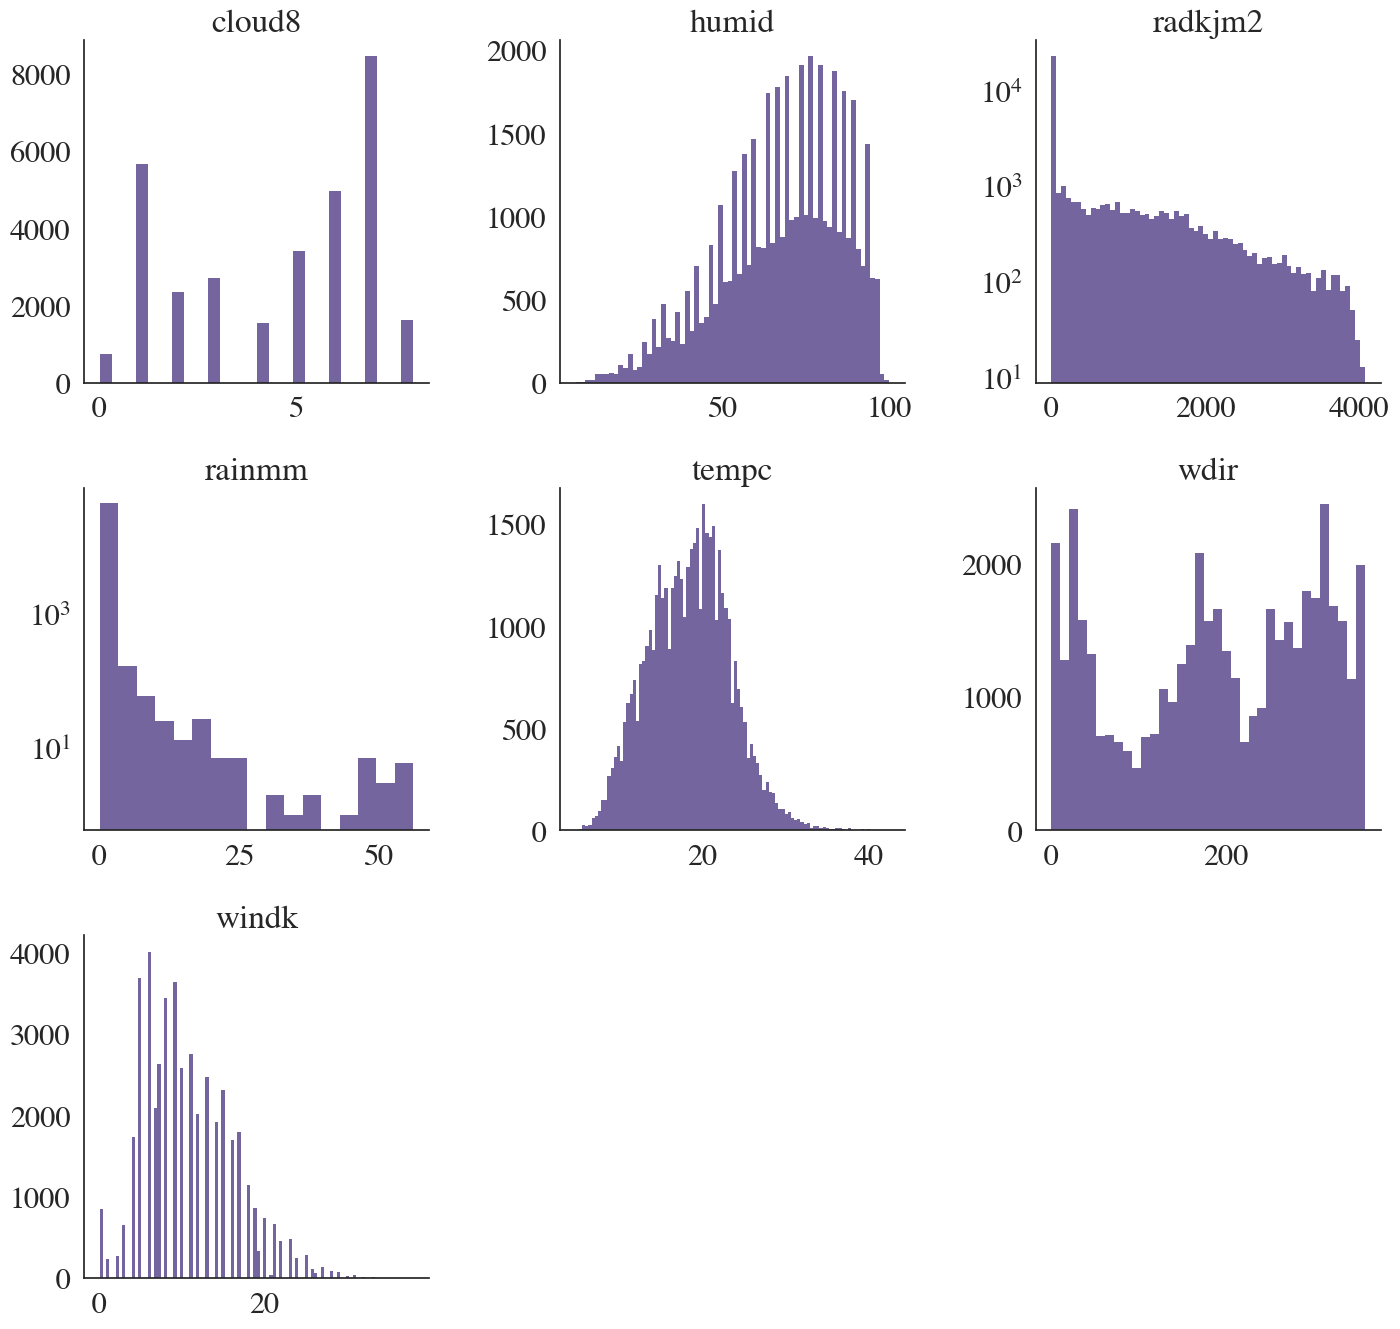

In [29]:
hist_vals_syd = [x + '_syd' for x in hist_vals]
hist_df = df[df['region'] == 'nsw'][hist_ids + hist_vals_syd].rename(
    {old: new for old, new in zip(hist_vals_syd, hist_vals)}, axis=1).melt(
        id_vars=hist_ids, value_vars=hist_vals)
g = sns.displot(hist_df, x='value', col='variable', col_wrap=3, kind='hist',
            facet_kws={'sharex': False, 'sharey': False}, common_bins=False)
for col, ax in g.axes_dict.items():
    if col in log_vals:
        ax.set(yscale='log')
g.set_axis_labels('', '')
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.9)
g.savefig('../plots/weather_hist_syd')

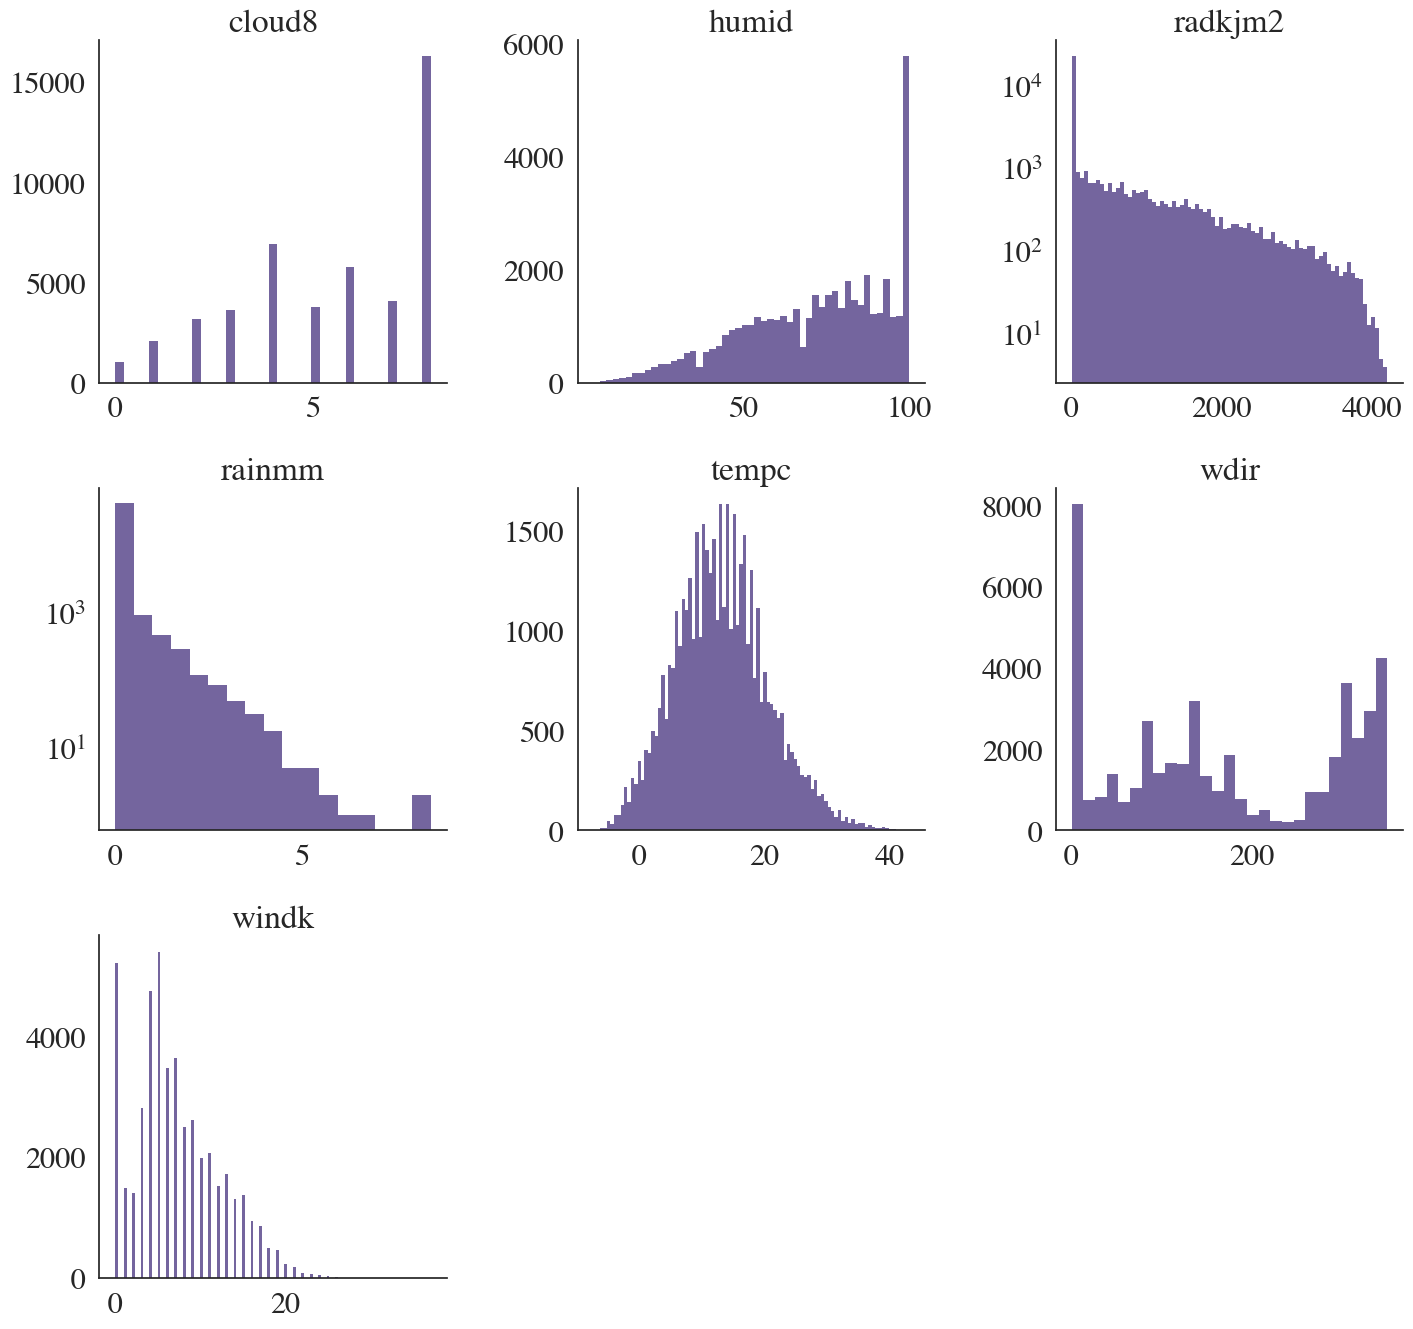

In [30]:
hist_vals_cbr = [x + '_cbr' for x in hist_vals]
hist_df = df[df['region'] == 'nsw'][hist_ids + hist_vals_cbr].rename(
    {old: new for old, new in zip(hist_vals_cbr, hist_vals)}, axis=1).melt(
        id_vars=hist_ids, value_vars=hist_vals)
g = sns.displot(hist_df, x='value', col='variable', col_wrap=3, kind='hist',
            facet_kws={'sharex': False, 'sharey': False}, common_bins=False)
for col, ax in g.axes_dict.items():
    if col in log_vals:
        ax.set(yscale='log')
g.set_axis_labels('', '')
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.9)
g.savefig('../plots/weather_hist_cbr')

Is Canberra really that humid???

In [31]:
df['humid_cbr'].mean()

71.22133076593924

In [32]:
df[['humid_cbr', 'rainmm_cbr']].corr()

,humid_cbr,rainmm_cbr
humid_cbr,1.000000,0.198494
rainmm_cbr,0.198494,1.000000


# Correlations

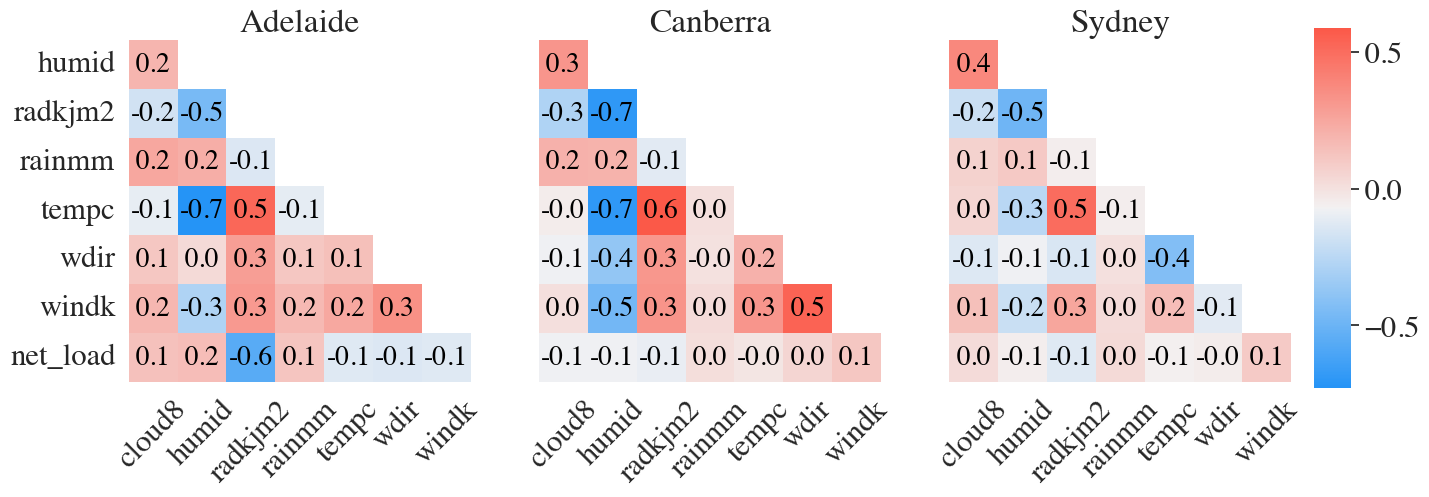

In [80]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 6))
cbar_ax = fig.add_axes([0.915, 0.2, 0.025, 0.6])

ade_corr = df[hist_vals+['net_load']].corr()
cbr_corr = df[hist_vals_cbr+['net_load']].rename({old: new for old, new in zip(hist_vals_cbr, hist_vals)}, axis=1).corr()
syd_corr = df[hist_vals_syd+['net_load']].rename({old: new for old, new in zip(hist_vals_syd, hist_vals)}, axis=1).corr()

mask = np.triu(np.ones_like(ade_corr, dtype=bool))
cmap = sns.diverging_palette(250, 15, s=95, l=60, center="light", as_cmap=True)
fmt = '.1f'
annot_kws = {'size': 'small', 'color': 'black'}
vmin = min(d.mask(mask).stack().min() for d in [ade_corr, cbr_corr, syd_corr])
vmax = max(d.mask(mask).stack().max() for d in [ade_corr, cbr_corr, syd_corr])

sns.heatmap(ade_corr.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, annot_kws=annot_kws, fmt=fmt, cmap=cmap, vmin=vmin, vmax=vmax, ax=axes[0], cbar=False)
sns.heatmap(cbr_corr.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, annot_kws=annot_kws, fmt=fmt, cmap=cmap, vmin=vmin, vmax=vmax, ax=axes[1], cbar=False)
sns.heatmap(syd_corr.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, annot_kws=annot_kws, fmt=fmt, cmap=cmap, vmin=vmin, vmax=vmax, ax=axes[2], cbar_ax=cbar_ax)

for ax, city in zip(axes, ['Adelaide', 'Canberra', 'Sydney']):
    ax.set_title(city)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_aspect('equal')
fig.savefig('../plots/correlations')

# Missing values

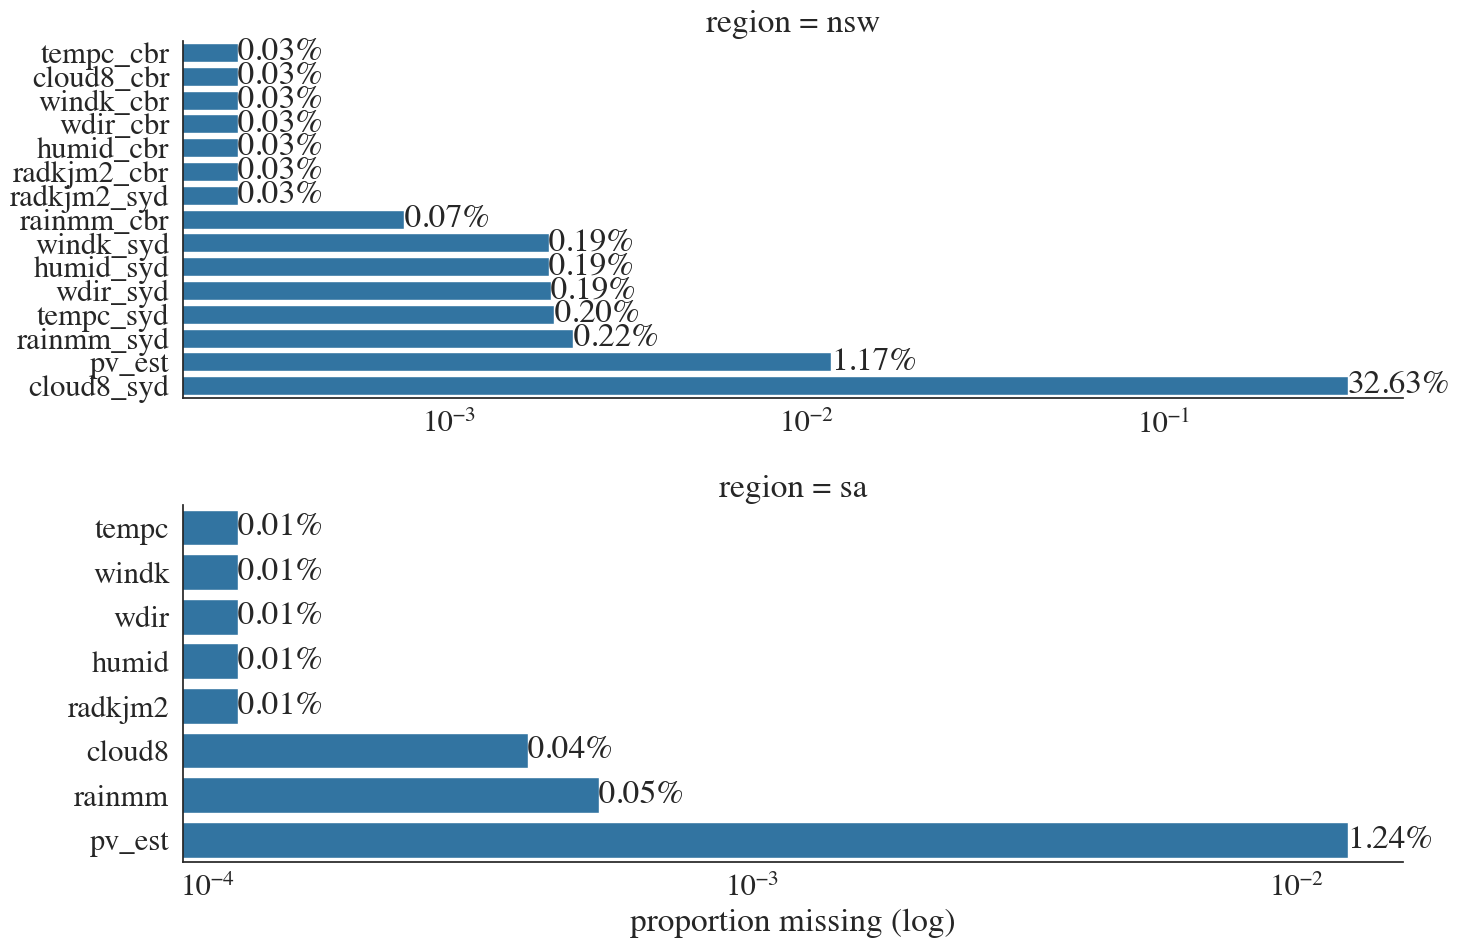

In [34]:
missing = []
for r, d in zip(regions, dfs):
    miss = d.isna().sum() / len(d)
    miss = miss[miss > 0].sort_values().to_frame()
    miss.columns = ['proportion missing (log)']
    miss.index.variables = ['variable']
    miss['variable'] = miss.index
    miss['region'] = r
    missing.append(miss)
missing_df = pd.concat(missing)
ax = sns.catplot(y='variable', x='proportion missing (log)', data=missing_df, row='region', 
                 kind='bar', sharex=False, sharey=False, aspect=3, color='tab:blue')
for x in ax.axes.ravel():
    for c in x.containers:
        labels = [f"{round(v.get_width(), 4):.2%}" for v in c]
        x.bar_label(c, labels=labels, label_type='edge')
ax = ax.set(xscale='log', ylabel='')
#ax.savefig('../plots/missing_bar.png')

## Adelaide

In [35]:
df[np.logical_and(df['region'] == 'sa', df['tempc'].isna())]

,datetime,net_load,total_load,pv_est,tempc_cbr,cloud8_cbr,windk_cbr,wdir_cbr,humid_cbr,rainmm_cbr,...,radkjm2_syd,region,year,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2
4489,2018-09-09 11:00:00,913.5,681.735,456.9540,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,sa,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4490,2018-09-09 12:00:00,856.0,644.545,529.0250,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,sa,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4491,2018-09-09 13:00:00,823.5,656.135,542.3950,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,sa,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4492,2018-09-09 14:00:00,840.0,664.160,506.6235,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,sa,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4493,2018-09-09 15:00:00,896.0,718.190,413.5680,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,sa,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All weather obs missing from 2018-09-09 midday

In [36]:
cloud = df.loc[np.logical_and(df['region'] == 'sa', df['cloud8'].isna()), 'datetime']
rain = df.loc[np.logical_and(df['region'] == 'sa', df['rainmm'].isna()), 'datetime']
#print(cloud)
#print(rain)
#print(np.intersect1d(cloud, rain))

Additional cloud and rain obs missing mostly "at random"

In [37]:
df.loc[np.logical_and(df['region'] == 'sa', df['pv_est'].isna()), 'datetime'].dt.date.unique().astype('str')

array(['2018-03-08', '2018-08-17', '2020-12-16', '2020-12-17',
       '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
       '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
       '2022-06-10', '2022-06-11', '2022-06-12', '2022-06-13',
       '2022-06-18', '2022-06-19', '2022-06-20', '2022-06-21',
       '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25',
       '2022-06-26', '2022-09-12', '2022-12-19', '2022-12-20',
       '2022-12-21'], dtype='<U10')

pv_est missing from 2-26 June 2022, 19-21 December 2022, other smaller windows

## Canberra

In [38]:
df.loc[np.logical_and(df['region'] == 'nsw', df['rainmm_cbr'].isna()), :]

,datetime,net_load,total_load,pv_est,tempc_cbr,cloud8_cbr,windk_cbr,wdir_cbr,humid_cbr,rainmm_cbr,...,radkjm2_syd,region,year,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2
1141,2018-04-22 23:00:00,7132.5,7085.550000,0.0000,12.7,4.0,6.0,140.0,93.0,NaN,...,0.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1142,2018-04-23 00:00:00,6967.0,6920.965000,0.0000,11.0,5.0,4.0,350.0,96.0,NaN,...,0.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1143,2018-04-23 01:00:00,6706.0,6620.430000,0.0000,8.4,6.0,1.0,90.0,94.0,NaN,...,0.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1144,2018-04-23 02:00:00,6437.0,6386.615000,0.0000,8.4,6.0,1.0,150.0,99.0,NaN,...,0.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1145,2018-04-23 03:00:00,6050.0,6004.865000,0.0000,7.8,6.0,0.0,0.0,99.0,NaN,...,0.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1146,2018-04-23 04:00:00,5875.5,5857.610000,0.0000,8.0,7.0,4.0,120.0,100.0,NaN,...,0.0,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4489,2018-09-09 11:00:00,7089.5,6821.565000,932.5805,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4490,2018-09-09 12:00:00,6778.5,6508.170000,990.8740,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4491,2018-09-09 13:00:00,6535.5,6281.300000,939.0040,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4492,2018-09-09 14:00:00,6420.5,6163.580000,873.2300,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,nsw,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Same/similar 2018-09-09 window missing from both adelaide and canberra, plus others mostly "at random"

## Sydney

In [39]:
df.loc[np.logical_and(df['region'] == 'nsw', df['radkjm2_syd'].isna()), ['datetime']+hist_vals_syd]

,datetime,cloud8_syd,humid_syd,radkjm2_syd,rainmm_syd,tempc_syd,wdir_syd,windk_syd
4489,2018-09-09 11:00:00,NaN,35.0,NaN,0.0,19.7,230.0,15.995530
4490,2018-09-09 12:00:00,NaN,29.0,NaN,0.0,20.2,240.0,17.993757
4491,2018-09-09 13:00:00,NaN,28.0,NaN,0.0,21.4,260.0,13.023460
4492,2018-09-09 14:00:00,NaN,27.0,NaN,0.0,22.5,280.0,15.021686
4493,2018-09-09 15:00:00,NaN,25.0,NaN,0.0,22.4,290.0,13.023460
44279,2023-03-25 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44280,2023-03-25 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44281,2023-03-25 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44282,2023-03-25 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44283,2023-03-25 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Same 2018-09-09 and 2023-03-25 windows missing from both NSW sites

In [40]:
df.loc[df['region'] == 'sa', 'datetime'].describe(datetime_is_numeric=True)[['min', 'max']]

min    2018-03-06 10:00:00
max    2023-03-08 00:00:00
Name: datetime, dtype: object

2023-03-25 missing window doesn't matter if full merged dataset is limited by SA's date range

In [41]:
wind_syd = df.loc[np.logical_and(df['region'] == 'nsw', df['windk_syd'].isna()), 'datetime'].dt.date.unique().astype('str')
wind_syd

array(['2018-03-09', '2018-03-11', '2018-03-12', '2018-03-13',
       '2018-03-14', '2018-03-16', '2018-03-17', '2018-03-18',
       '2018-03-19', '2018-03-20', '2018-03-21', '2018-03-22',
       '2018-03-23', '2018-03-24', '2018-03-25', '2018-03-26',
       '2018-03-28', '2018-03-29', '2018-03-31', '2018-04-01',
       '2018-04-02', '2018-09-24', '2018-10-16', '2018-12-01',
       '2019-06-05', '2019-06-06', '2019-09-10', '2020-06-18',
       '2020-11-19', '2020-12-09', '2020-12-28', '2021-01-22',
       '2021-02-04', '2021-02-07', '2021-03-28', '2021-04-13',
       '2021-06-07', '2021-06-16', '2021-10-06', '2022-03-21',
       '2022-05-04', '2022-05-25', '2023-03-25'], dtype='<U10')

In [42]:
others_syd = df.loc[
    np.logical_and(
        df['region'] == 'nsw', 
        np.any(df[['humid_syd', 'wdir_syd', 'tempc_syd', 'rainmm_syd']].isna(), axis=1)
    ), 'datetime'].dt.date.unique().astype('str')
np.mean([x in wind_syd for x in others_syd])

0.8113207547169812

Vast majority of missing sydney weather is shared, e.g. all tend to be missing from the same days

<Axes: xlabel='datetime', ylabel='cloud_missing'>

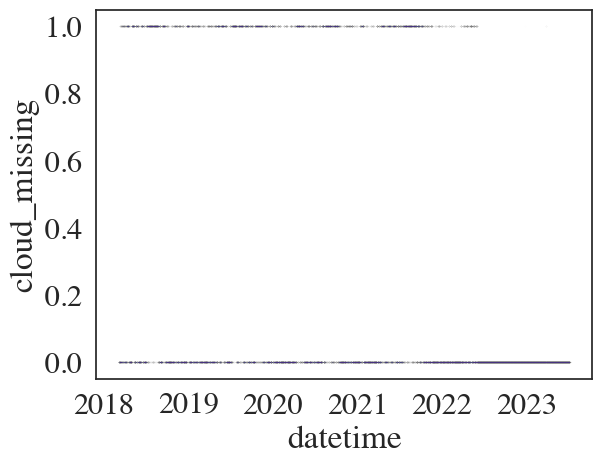

In [43]:
cloud_syd = df.loc[df['region'] == 'nsw', ['datetime', 'cloud8_syd']]
cloud_syd['cloud_missing'] = cloud_syd['cloud8_syd'].isna().astype('int')
cloud_syd.plot(x='datetime', y='cloud_missing', kind='scatter', s=0.1, alpha=0.01)

Sydney cloud data missing mostly at random throughout 2018-2022

In [44]:
df.loc[np.logical_and(df['region'] == 'nsw', df['pv_est'].isna()), 'datetime'].dt.date.unique().astype('str')

array(['2018-03-08', '2018-08-17', '2020-12-16', '2020-12-17',
       '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
       '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
       '2022-06-10', '2022-06-11', '2022-06-12', '2022-06-13',
       '2022-06-18', '2022-06-19', '2022-06-20', '2022-06-21',
       '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25',
       '2022-06-26', '2022-09-12', '2022-12-19', '2022-12-20',
       '2022-12-21', '2023-03-08', '2023-03-09'], dtype='<U10')

In [45]:
np.union1d(
    df.loc[np.logical_and(df['region'] == 'nsw', df['pv_est'].isna()), 'datetime'].dt.date.unique().astype('str'),
    df.loc[np.logical_and(df['region'] == 'sa', df['pv_est'].isna()), 'datetime'].dt.date.unique().astype('str')
)

array(['2018-03-08', '2018-08-17', '2020-12-16', '2020-12-17',
       '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
       '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
       '2022-06-10', '2022-06-11', '2022-06-12', '2022-06-13',
       '2022-06-18', '2022-06-19', '2022-06-20', '2022-06-21',
       '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25',
       '2022-06-26', '2022-09-12', '2022-12-19', '2022-12-20',
       '2022-12-21', '2023-03-08', '2023-03-09'], dtype='<U10')

NSW pv_est missing from same dates as SA pv_est